### Mass Spectra Analysis Code
#### Jeffrey Kwarsick, Ph.D.
#### Nov 2020

Having studied physical chemistry for many years meant that I would be exposed to the technique of mass spectrometry.  Mass spectrometry, roughly speaking, involves ionizing your material of interest and then measuring its mass-to-charge ratio.  If you are interested in getting a better understanding, I would recommend checking out the Wikipedia Article (https://en.wikipedia.org/wiki/Mass_spectrometry)!  Overall, this is an increibly powerful technique with a wide array of applications and this Jupyter Notebook dives into the analysis of typical mass spectra.

In [12]:
import os
import re
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.patches import Ellipse
import matplotlib.transforms as transforms
import math
import scipy as sci
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error
import time
from datetime import datetime
plt.style.use('ggplot')

### Functions
Here is a list of functions that I built in order to analyze a mass spectrum
- `count_lines()`: counts the lines in a file
- `extractor()`: extracts datapoint, x-values, and y-values
- `find_peaks()`: finds indices of peaks with y-value > threshold
- `parabola()`:  Given (x,y) values of three points calculate the vertex of parabola these points.  The vertex where the derivative of the parabola is zero.
- `find_vertex()`: Given all x-values, all y-values, and indices of peaks (>threshold), calculate the vertex (x,y) for the peak in mass spectrum
- `plot_vert`: plots vertical lines for centroids of all peaks above given threshold.

In [ ]:
def count_lines(datafile):
    """
    Open file and read lines.
    
    Input: 
        file -- .txt
    --------------------------
    Return: 
        number of lines in files, int or float
    """
    line_counter = 0
    grab_lines = False
    with open(datafile) as infile:
        for line in infile:
            line_counter += 1
    return(line_counter)

In [49]:
def extractor(datafile):
    """
    Go through all lines in file.  Use regex to extract datapoint x and y information.
    Return values as dataframe and convert x and y data to floats
    
    Input: 
        Datafile -- mass spectra .txt file
    ----------------------------------------
    Output:
        Dataframe = [Datapoint, xvalue, yvalue]
    
    """
    datapoint, xunit, xvalue, yunit, yvalue, time = [], [], [], [], [], []
    re_datapoint, re_xunit, re_xvalue, re_yunit, re_yvalue, re_time = r'datapoint', r'xunit', r'xvalue', r'yunit', r'yvalue', r'time'
    re_grab_value = r'(?<=>\s)[0-9.]+'
    with open(datafile) as infile:
        for line in infile:
            if re.search(re_datapoint, line) is not None:
                datapoint.extend(re.findall(re_grab_value, line))
            #elif re.search(re_xunit, line) is not None:
                #xunit.extend(re.findall(re_grab_value, line))
            elif re.search(re_xvalue, line) is not None:
                xvalue.extend(re.findall(re_grab_value, line))
            #elif re.search(re_yunit, line) is not None:
                #yunit.extend(re.findall(re_grab_value, line))
            elif re.search(re_yvalue, line) is not None:
                yvalue.extend(re.findall(re_grab_value, line))
            #elif re.search(re_time, line) is not None:
                #time.extend(re.findall(re_grab_value, line))
    datapoint = [int(datapoint[i]) for i in range(len(datapoint))]
    xvalue = [float(xvalue[i]) for i in range(len(xvalue))]
    yvalue = [float(yvalue[i]) for i in range(len(yvalue))]
    #time = [float(time[i]) for i in range(len(time))]
    exportdf = pd.DataFrame(zip(datapoint,xvalue,yvalue), columns=['datapoint','xvalue', 'yvalue'])
    return(exportdf)

In [22]:
def find_peaks(yvals, threshold):
    """
    Find all peaks in spectra with value > threshold
    
    Input:
        yvals: array of floats of spectra intensity values
        threshold: int/float 
    -------------------------------------------------------
    Output:
        peaks: array of floats containing indices of yval > threshold
    """
    peaks = []
    for i in range(len(yvals)):
        if yvals[i] > threshold and yvals[i] > yvals[i-1] and yvals[i] > yvals[i+1]:
            peaks.append(i)
    return(peaks)

In [48]:
def parabola(nxvals, nyvals):
    """
    Given (x,y) values of three points calculate the vertex of parabola these points form
    The vertex where the derivative of the parabola is zero.
    
    Inputs:
        nxvals: list or np.array of x-values
        nyvals: list or np.array of y-values
    -------------------------------------------------------------------------------------
    Outputs:
        list of x and y values of parabola vertex
    """
    x_sqr = list(np.power(nxvals, 2.0))
    xs = np.array([[x_sqr[0],nxvals[0],1.], [x_sqr[1],nxvals[1],1.],[x_sqr[2],nxvals[2],1.]])
    ys = np.array([[nyvals[0]],[nyvals[1]],[nyvals[2]]])
    xs_inv = np.linalg.inv(xs)
    abc = np.matmul(xs_inv, ys)
    xv = float(-abc[1])/(2.*float(abc[0]))
    yv = float(abc[2]) - (np.power(float(abc[1]),2.)/(4.*float(abc[0])))
    return(np.round(xv,5),np.round(yv,5))

In [26]:
def find_vertex(xvals,yvals,peaks):
    """
    Given all x-values, all y-values, and indices of peaks (>threshold)
    Calculate the vertex (x,y) for the peak in mass spectrum
    
    Input:
        xvals: np.array, dataframe column of x-values
        yvals: np.array, dataframe column of y-values
        peaks: list or np.array of indices of peaks (>threshold)
    --------------------------------------------------------------------    
    Output:
        centroids: array of vertices (x,y) of all peaks (>threshold) 
    """
    centroid = []
    for i in range(len(peaks)):
        prev,aft = peaks[i]-1, peaks[i]+1
        x = [xvals[prev], xvals[peaks[i]], xvals[aft]]
        y = [yvals[prev], yvals[peaks[i]], yvals[aft]]
        # call to parabola() function
        temp = parabola(x,y)
        centroid.append(temp)
    return(centroid)

In [50]:
def plot_vert(cents):
    """
    Given an x-value, plot vertical line
    Input:
        cents: array of x-values
    ------------------------------------
    Output:
        matplotlib function plt.axvline
    """
    for i in range(len(cents)):
        plt.axvline(cents[i][0], color='blue',ls='-')

### Run an Analysis with a sample dataset

In [51]:
file = 'mass_spec.txt'

In [52]:
tic = time.time()
data = extractor(file)
toc = time.time()
print("{:.2f}ms".format(toc-tic))
data.to_csv('mass_spec_export.csv')

0.44ms


In [53]:
data

,datapoint,xvalue,yvalue
0,1,150.000097,0.0
1,2,150.000233,0.0
2,3,150.000368,0.0
3,4,150.000504,0.0
4,5,150.024783,0.0
...,...,...,...
17010,17011,1445.798712,0.0
17011,17012,1499.964257,0.0
17012,17013,1499.977818,0.0
17013,17014,1499.991379,0.0


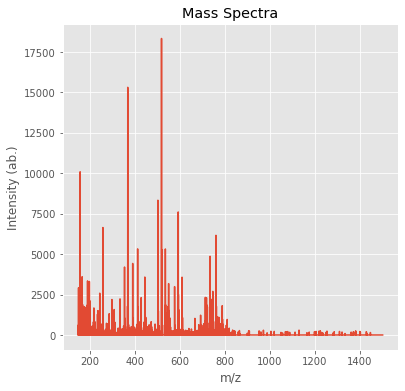

In [54]:
plt.figure(figsize=(6,6))
plt.plot(data["xvalue"], data["yvalue"])
plt.xlabel("m/z")
plt.ylabel("Intensity (ab.)")
plt.title("Mass Spectra")
plt.show()

In [55]:
tic = time.time()
peaks = find_peaks(data['yvalue'], 2000.)
centroids = find_vertex(data['xvalue'], data['yvalue'], peaks)
toc = time.time()
print("{:.2f}ms".format(toc-tic))

0.20ms


In [56]:
peaks

[73,
 331,
 472,
 652,
 1591,
 1897,
 1958,
 3106,
 3476,
 4283,
 5043,
 5338,
 5695,
 5817,
 5843,
 6234,
 6717,
 7217,
 7597,
 8777,
 8851,
 9260,
 9362,
 9417,
 9660,
 10117,
 10542,
 10944,
 10999,
 11252,
 12805,
 12999,
 13423,
 13587,
 13795,
 13848,
 14192,
 14238]

In [57]:
centroids

[(151.1118, 2979.0),
 (158.15399, 10176.5),
 (161.13255, 3313.25),
 (167.10672, 3664.5),
 (191.10431, 3402.6875),
 (199.16932, 3321.0625),
 (201.16385, 2147.28125),
 (245.0785, 2594.03125),
 (259.16691, 6652.25),
 (299.06174, 2205.4375),
 (335.12558, 2244.20312),
 (355.07004, 4214.875),
 (369.3517, 15371.125),
 (370.35511, 4080.40625),
 (371.10137, 2456.92188),
 (391.28444, 4474.67188),
 (413.26632, 5506.98438),
 (429.08887, 2356.6875),
 (445.12016, 3616.625),
 (503.10782, 8592.21875),
 (504.10686, 2915.42188),
 (519.13894, 18534.6875),
 (520.13809, 5320.10938),
 (521.13591, 4373.45312),
 (536.16589, 5442.54688),
 (550.62886, 3241.22656),
 (577.12665, 3009.94531),
 (593.15799, 7611.09375),
 (594.15728, 2608.66016),
 (610.18474, 3622.91406),
 (713.45222, 2373.51562),
 (718.53888, 2360.88672),
 (734.56955, 4922.82812),
 (739.46835, 2201.44141),
 (744.55392, 2261.52148),
 (746.56985, 2735.38672),
 (760.58562, 6342.63281),
 (761.58864, 3483.33594)]

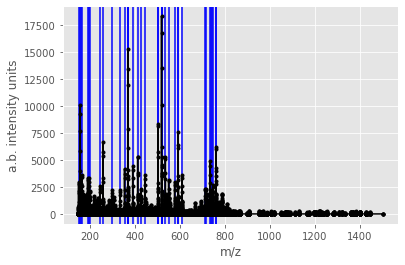

In [58]:
plot_vert(centroids)
plt.plot(data['xvalue'], data['yvalue'], "ko-", markersize=3)
plt.xlabel('m/z')
plt.ylabel('a.b. intensity units')
plt.grid(True)
plt.show()

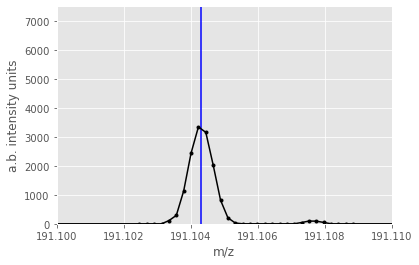

In [45]:
plot_vert(centroids)
plt.plot(data['xvalue'], data['yvalue'], "ko-", markersize=3)
plt.xlabel('m/z')
plt.ylabel('a.b. intensity units')
plt.grid(True)
plt.xlim([191.100, 191.110])
plt.ylim([0, 7500])
plt.show()